In [105]:
import pandas as pd
import collections
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import statsmodels as sm
import folium
import sys
import os
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from statsmodels.tsa.stattools import ccf, ccovf
import statsmodels
import statsmodels.tsa.stattools as ts
from statsmodels.tsa.stattools import acf, pacf
import warnings 
warnings.filterwarnings('ignore')

__Importing Data__

In [106]:
df_temp= pd.read_csv("COVID_19_us_temp.csv")
df_temp= df_temp.drop(['Unnamed: 0','Unnamed: 0.1'],axis=1)
us_date_confirmed = df_temp.groupby(['date'])['Confirmed'].sum().reset_index()
us_date_death = df_temp.groupby(['date'])['Deaths'].sum().reset_index()
df_temp_bystate=df_temp.groupby(["Province_State","date"])['Avg','Confirmed','Deaths'].sum().reset_index()
df_temp_bystate=pd.DataFrame(df_temp_bystate)
ndays=us_date_death.shape[0]
df_temp_bystate

,Province_State,date,Avg,Confirmed,Deaths
0,Arkansas,2020-02-01,46.6,0.0,0.0
1,Arkansas,2020-02-02,55.5,0.0,0.0
2,Arkansas,2020-02-03,61.0,0.0,0.0
3,Arkansas,2020-02-04,58.7,0.0,0.0
4,Arkansas,2020-02-05,40.3,0.0,0.0
...,...,...,...,...,...
5695,Wyoming,2020-05-20,65.1,787.0,11.0
5696,Wyoming,2020-05-21,56.3,801.0,12.0
5697,Wyoming,2020-05-22,60.8,803.0,12.0
5698,Wyoming,2020-05-23,57.7,813.0,12.0


### Part 1. Visualization for confirmed and death cases

In this part, we visualize the time series data for COVID-19 cases as well as average temperature series up to 05-24-2020 in selected states

Following Figures are the curves for COVID-19 data of US and each state. For visualization purpose, we did not consider the cases from Unassigned Location (e.g. Diamond Princess and Grand Princess Cruise Ship).

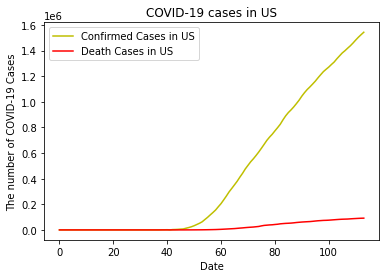

In [107]:
plt.plot([i for i in range(ndays)], us_date_confirmed['Confirmed'], 'y', label = 'Confirmed Cases in US')
plt.plot([i for i in range(ndays)], us_date_death['Deaths'], 'r', label = 'Death Cases in US')
plt.xlabel('Date')
plt.ylabel('The number of COVID-19 Cases')
plt.title('COVID-19 cases in US')
plt.legend()
plt.show()

We also collect the number of confirmed cases and death cases for each state. Based on the folium map, we see that the COVID-19 is kind of severe in __California__, __New York__, __Pennsylvania__, __Florida__ and __Washington__. Following are visualization for these selected states.

#### Part 1.1. Visualization for confirmed cases in selected states

Following figures are the visualization for confirmed cases for COVID-19 in __California__, __New York__, __Pennsylvania__, __Florida__ and __Washington__.

In [108]:
def plt_COVID_bystate(state):
    df=df_temp_bystate.loc[df_temp_bystate['Province_State'] == state]
    ndays_s=df.shape[0]
    plt.plot([i for i in range(ndays_s)], df['Confirmed'], 'y', label = 'Confirmed Cases in '+state)
    plt.plot([i for i in range(ndays_s)], df['Deaths'], 'r', label = 'Death Cases in '+state)
    plt.xlabel('Date')
    plt.ylabel('The number of COVID-19 Cases')
    plt.title('COVID-19 cases in '+state)
    plt.legend()
    plt.show()

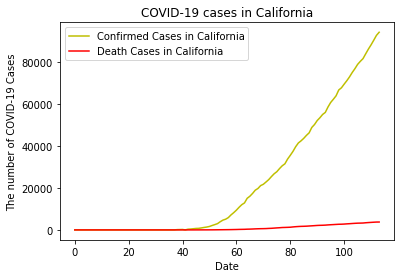

In [109]:
plt_COVID_bystate('California')

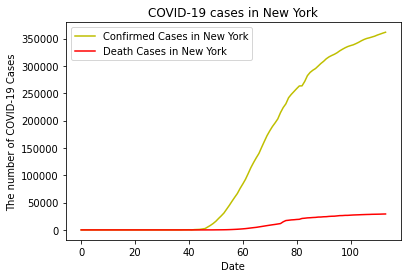

In [110]:
plt_COVID_bystate('New York')

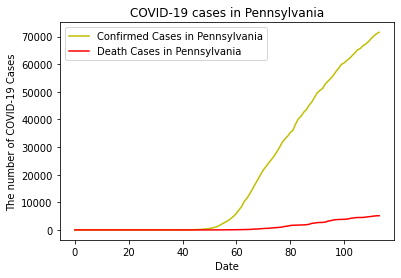

In [111]:
plt_COVID_bystate('Pennsylvania')

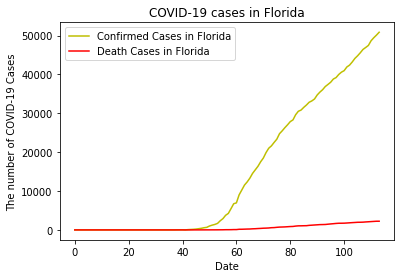

In [112]:
plt_COVID_bystate('Florida')

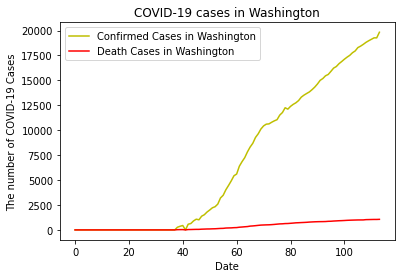

In [113]:
plt_COVID_bystate('Washington')

### Temperature

Following figures are the visualization of confirmed cases and deaths cases along with average temperatures in selected states. __The blue line is for average temperatures, the yellow line is for confirmed cases and the red line is for death cases.__

In [114]:
def select_data(state):
    df1=df_temp_bystate.loc[df_temp_bystate['Province_State'] == state]
    return df1

In [115]:
def plot_with_temp(state):
    ts_tot=select_data(state)
    n_sample = ts_tot.shape[0]
    n_train=int(0.8*n_sample)+1
    n_forecast=n_sample-n_train
    ts_confirmed = ts_tot['Confirmed']
    ts_deaths = ts_tot['Deaths']
    ts_tempe = ts_tot['Avg']
    
    fig,ax = plt.subplots()
    ax.plot([i+1 for i in range(n_sample)],ts_confirmed, color="y", label = 'Confirmed Cases in '+state)
    ax.set_xlabel("Date",fontsize=14)
    ax.set_ylabel("Number of Cases", fontsize=14)
    plt.legend()
    
    ax2=ax.twinx()
    ax2.plot([i+1 for i in range(n_sample)],ts_tempe,color="blue")
    ax2.set_ylabel("Average Temperature", fontsize=14)
    plt.title('COVID-19 Confirmed Cases with Average Temperatures in '+state)
    plt.show()
    
    fig,ax = plt.subplots()
    ax.plot([i+1 for i in range(n_sample)],ts_deaths, color="r", label = 'Death Cases in '+state)
    ax.set_xlabel("Date",fontsize=14)
    ax.set_ylabel("Number of Cases", fontsize=14)
    plt.legend()
    
    ax2=ax.twinx()
    ax2.plot([i+1 for i in range(n_sample)],ts_tempe,color="blue")
    ax2.set_ylabel("Average Temperature", fontsize=14)
    plt.title('COVID-19 Death Cases with Average Temperatures in '+state)
    plt.show()

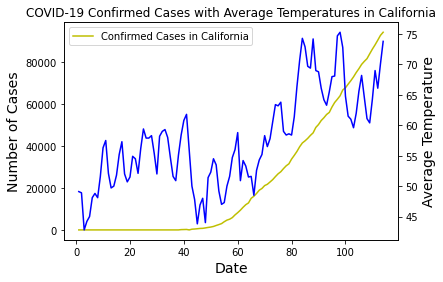

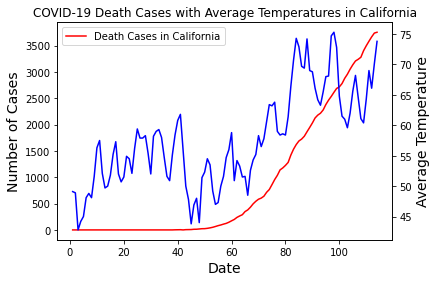

In [116]:
plot_with_temp('California')

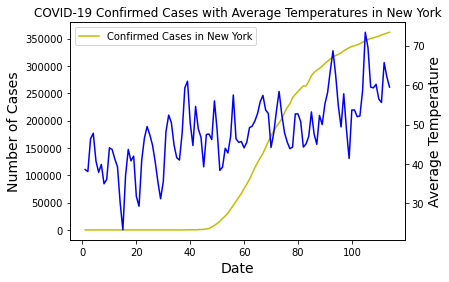

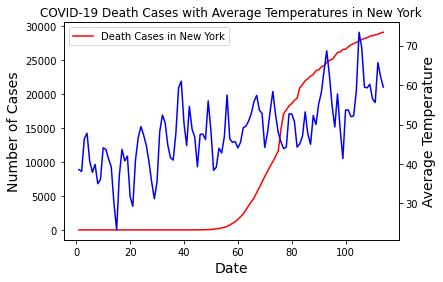

In [117]:
plot_with_temp('New York')

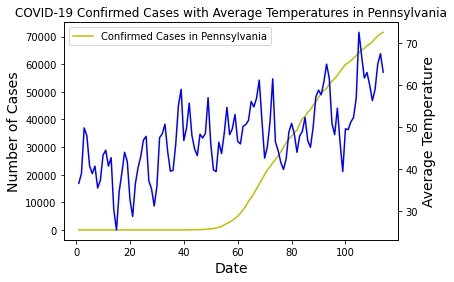

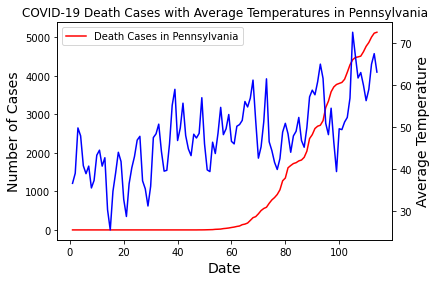

In [118]:
plot_with_temp('Pennsylvania')

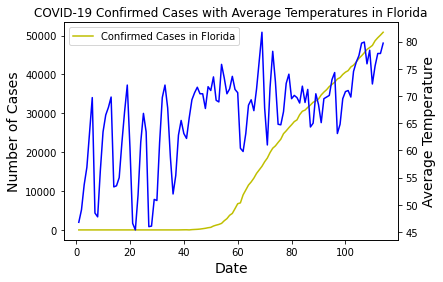

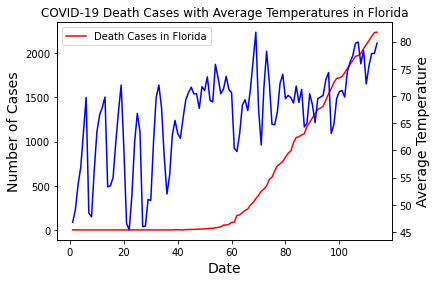

In [119]:
plot_with_temp('Florida')

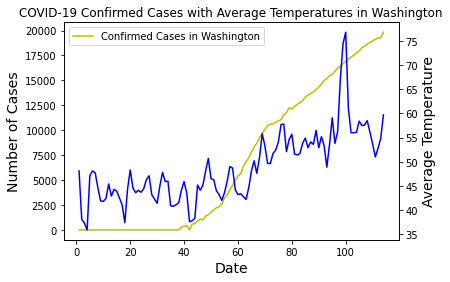

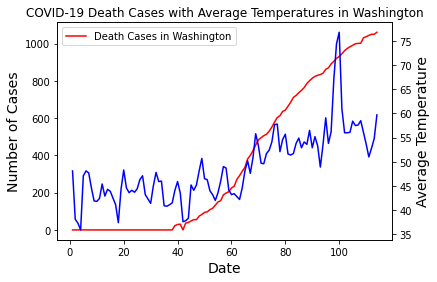

In [120]:
plot_with_temp('Washington')

### Summary

Based on the visualization above, it seems that the confirmed cases and death cases in __California__ and __Washington__ is related to their average temperatures because they have similar trend in general for California and Washington. However, in other states, there is no obvious similar trend between daily average temperature and confirmed cases, or between daily average temperature and death cases. Therefore, we may expect to add temperatures into our analysis.